# **Import data from github**

In [ ]:
!wget "https://ndownloader.figshare.com/files/24753842?private_link=c20215f3d42c98f09ad0"

In [ ]:
!mkdir dicom

In [ ]:
!unzip "/content/24753842?private_link=c20215f3d42c98f09ad0" -d "/content/dicom/"

# **Import libraries**

In [ ]:
!pip install SimpleITK==2.0.0

In [ ]:
#import pydicom as dicom
import SimpleITK as sitk

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import nibabel as nib

import tensorflow as tf
import keras

import os
import random

import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2 as cv
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, Concatenate, UpSampling2D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.models import Sequential, save_model, load_model

from keras.losses import binary_crossentropy
from keras import backend as K

import tqdm
import pickle
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
img_size = 128

# **Laod the model**

**Define loss function and metrics**

weighted_dice_loss:

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f**2) + K.sum(y_pred_f**2) + smooth)
    return 1.0 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

#def bce_logdice_loss(y_true, y_pred):
#    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

'''
def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss
'''

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

surfaceloss:

In [ ]:
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.compat.v1.py_func(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

sum them up:

In [ ]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback

class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

Other Metrics:

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [ ]:
def iou(y_true, y_pred, smooth = 0.0001):
  intersection = K.sum(y_true * y_pred)
  sum_ = K.sum(y_true + y_pred)
  jac = (intersection + smooth) / (sum_ - intersection + smooth)
  return jac

**Define Unet**

In [ ]:
def unet(input_size=(128,128,1), dfilters=64, ufilters=64, dropout_rate=0.5):
    inputs = Input(input_size)
    
    conv1 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(bn1)
    bn1 = Activation('relu')(conv1)
    pool1=MaxPooling2D((2,2))(bn1)
    ################################################################################
    conv2 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(pool1)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation('relu')(bn2)
    conv2 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(bn2)
    bn2 = BatchNormalization()(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D((2,2))(bn2)
    ################################################################################
    conv3 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(pool2)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation('relu')(bn3)
    conv3 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(bn3)
    bn3 = BatchNormalization()(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D((2,2))(bn3)
    ################################################################################
    conv4 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(pool3)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation('relu')(bn4)
    conv4 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(bn4)
    bn4 = BatchNormalization()(conv4)
    bn4 = Activation('relu')(bn4)
    bn4 = Dropout(dropout_rate)(bn4)
    pool4 = MaxPooling2D((2,2))(bn4)
    ################################################################################
    conv5 = Conv2D(dfilters*16,kernel_size=(3,3),strides=(1,1),padding='same')(pool4)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation('relu')(bn5)
    conv5 = Conv2D(dfilters*16,kernel_size=(3,3),strides=(1,1),padding='same')(bn5)
    bn5 = BatchNormalization()(conv5)
    bn5 = Activation('relu')(bn5)
    bn5 = Dropout(dropout_rate)(bn5)
    ################################################################################
    up6 = UpSampling2D((2,2))(bn5)
    conv6 = Conv2D(dfilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(up6)
    bn6 = BatchNormalization()(conv6)
    bn6 = Activation('relu')(bn6)
    
    atb_g6 = Conv2D(ufilters*8,kernel_size=(1,1),strides=(1,1),padding='valid')(bn6)
    atb_g6 = BatchNormalization()(atb_g6)
    atb_x6 = Conv2D(ufilters*8,kernel_size=(1,1),strides=(1,1),padding='valid')(bn4)
    atb_x6 = BatchNormalization()(atb_x6)
    psi6 = Add()([atb_g6,atb_x6])
    psi6 = Activation('relu')(psi6)
    psi6 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi6)
    psi6 = BatchNormalization()(psi6)
    conv6 = Activation('sigmoid')(psi6)
    
    up6 = Concatenate()([up6,conv6])
    
    conv6 = Conv2D(ufilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(ufilters*8,kernel_size=(3,3),strides=(1,1),padding='same')(bn6)
    bn6 = Activation('relu')(conv6)
    ################################################################################
    up7 = UpSampling2D((2,2))(bn6)
    conv7 = Conv2D(dfilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(up7)
    bn7 = BatchNormalization()(conv7)
    bn7 = Activation('relu')(bn7)
    
    atb_g7 = Conv2D(ufilters*4,kernel_size=(1,1),strides=(1,1),padding='valid')(bn7)
    atb_g7 = BatchNormalization()(atb_g7)
    atb_x7 = Conv2D(ufilters*4,kernel_size=(1,1),strides=(1,1),padding='valid')(bn3)
    atb_x7 = BatchNormalization()(atb_x7)
    psi7 = Add()([atb_g7,atb_x7])
    psi7 = Activation('relu')(psi7)
    psi7 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi7)
    psi7 = BatchNormalization()(psi7)
    conv7 = Activation('sigmoid')(psi7)
    
    up7 = Concatenate()([up7,conv7])
    
    conv7 = Conv2D(ufilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(ufilters*4,kernel_size=(3,3),strides=(1,1),padding='same')(bn7)
    bn7 = Activation('relu')(conv7)
    ################################################################################
    up8 = UpSampling2D((2,2))(bn7)
    conv8 = Conv2D(dfilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(up8)
    bn8 = BatchNormalization()(conv8)
    bn8 = Activation('relu')(bn8)
    
    atb_g8 = Conv2D(ufilters*2,kernel_size=(1,1),strides=(1,1),padding='valid')(bn8)
    atb_g8 = BatchNormalization()(atb_g8)
    atb_x8 = Conv2D(ufilters*2,kernel_size=(1,1),strides=(1,1),padding='valid')(bn2)
    atb_x8 = BatchNormalization()(atb_x8)
    psi8 = Add()([atb_g8,atb_x8])
    psi8 = Activation('relu')(psi8)
    psi8 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi8)
    psi8 = BatchNormalization()(psi8)
    conv8 = Activation('sigmoid')(psi8)
    
    up8 = Concatenate()([up8,conv8])
    
    conv8 = Conv2D(ufilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(ufilters*2,kernel_size=(3,3),strides=(1,1),padding='same')(bn8)
    bn8 = Activation('relu')(conv8)
    ################################################################################
    up9 = UpSampling2D((2,2))(bn8)
    conv9 = Conv2D(dfilters,kernel_size=(3,3),strides=(1,1),padding='same')(up9)
    bn9 = BatchNormalization()(conv9)
    bn9 = Activation('relu')(bn9)
    
    atb_g9 = Conv2D(ufilters,kernel_size=(1,1),strides=(1,1),padding='valid')(bn9)
    atb_g9 = BatchNormalization()(atb_g9)
    atb_x9 = Conv2D(ufilters,kernel_size=(1,1),strides=(1,1),padding='valid')(bn1)
    atb_x9 = BatchNormalization()(atb_x9)
    psi9 = Add()([atb_g9,atb_x9])
    psi9 = Activation('relu')(psi9)
    psi9 = Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi9)
    psi9 = BatchNormalization()(psi9)
    conv9 = Activation('sigmoid')(psi9)
    
    up9 = Concatenate()([up9,conv9])
    
    conv9 = Conv2D(ufilters,kernel_size=(3,3),strides=(1,1),padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(ufilters,kernel_size=(3,3),strides=(1,1),padding='same')(bn9)
    bn9 = Activation('relu')(conv9)
    ################################################################################
    outputs = Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(bn9)
    
    model = Model(inputs=inputs,outputs=outputs)
    
    return model

**Compile and fit the model**

In [ ]:
weight_path="{}_weights.augmenteddicesurface.hdf5".format('model')
checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

In [ ]:
BATCH_SIZE = 32
learning_rate = 1e-4
EPOCHS = 50

In [ ]:
model = unet(input_size=(img_size, img_size, 1))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

model.compile(optimizer=opt, loss=gl_sl_wrapper(alpha), metrics=[dice_coef, iou])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
weight_path = 'path to the saved model/model_dice_surface_aug.h5'
model.load_weights(weight_path)

# **load the dicom data and metadata**

In [ ]:
data_csv = pd.read_csv("/content/dicom/Index.csv")

In [ ]:
data_csv.head()

,Label Index,Diagnosis,Path,Folder
0,0,COVID-19,./COVID-19/,P001
1,1,COVID-19,./COVID-19/,P002
2,2,COVID-19,./COVID-19/,P003
3,3,COVID-19,./COVID-19/,P004
4,4,COVID-19,./COVID-19/,P005


*italicized text*# **set the covid path for test:**

In [ ]:
covid_path = "/content/dicom/COVID-19 subjects/P027"

In [ ]:
def get_pixels_hu(path):
    series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(path)
    sid = series_id[0]
    reader = sitk.ImageSeriesReader()
    image = sitk.ReadImage(reader.GetGDCMSeriesFileNames(path, sid))
    image = sitk.GetArrayFromImage(image)
    return image

Number of slices:  134
shape of series:  (134, 512, 512)


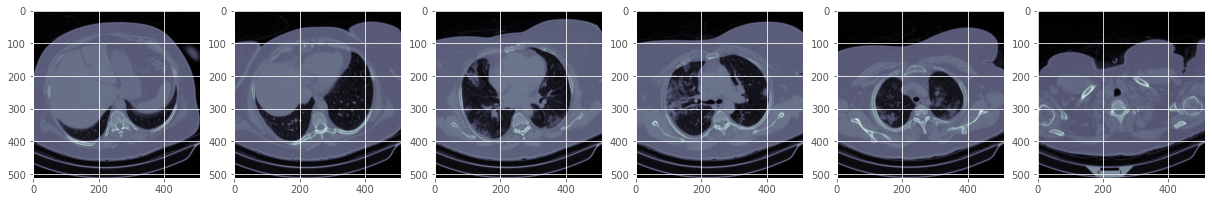

In [ ]:
arr = get_pixels_hu(covid_path)
slices = arr.shape[0]
print('Number of slices: ', slices)
print("shape of series: ", arr.shape)

arr = arr[range(25,140,20),:,:]

fig, axes = plt.subplots(1, 6, figsize=(21,10))  
for i in range(0,6):
  plt.subplot(1,6,i+1)
  plt.imshow(arr[i][...], cmap = 'bone')


## **Histogram Equalization**

In [ ]:
img_size = 128
clahe = cv.createCLAHE(clipLimit=4.0)

def clahe_enhancer(img, clahe, axes):
    '''Contract Limited Adaptive Histogram Equalizer'''
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])

        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)

Number of slices:  134
shape of series:  (134, 512, 512)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


shape after histogram equlizer (128, 128)


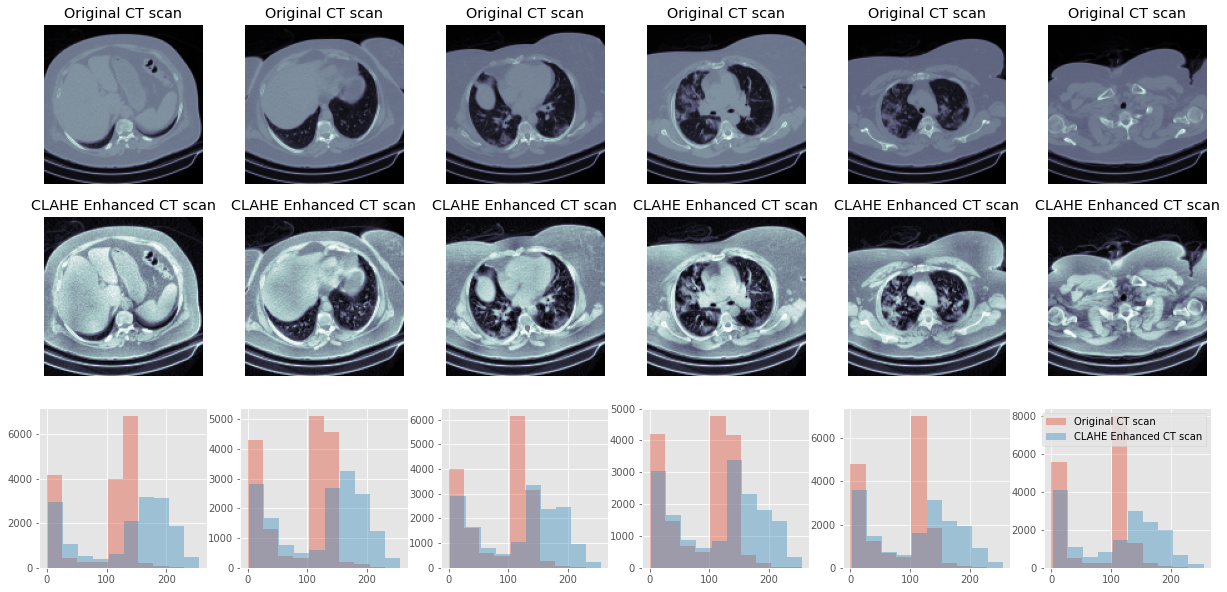

In [ ]:
cts = get_pixels_hu(covid_path)
slices = cts.shape[0]
print('Number of slices: ', slices)
print("shape of series: ", cts.shape)

cts = cts[range(20,140,20),:,:]

fig, axes = plt.subplots(3, 6, figsize=(21,10))    

for ii in range(cts.shape[0]):
    img = cv.resize(cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

print("shape after histogram equlizer", clahe_img.shape)

# **Load data and preprocessing**

In [ ]:
def load_data(covid_path):
  cts_all = []
  max_w, max_h = 0, 0 #max width and height
  arr_cts = get_pixels_hu(covid_path)
  arr_cts = arr_cts[ round(slices*0.2):round(slices*0.8), :, :]
  for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cts_all.append(clahe_ct)
  
  return(cts_all)

In [ ]:
def resize_del(cts_all):
  num_pix = 128
  del_lst = []
  for ii in tqdm.tqdm(range(len(cts_all))) :
      try :
          cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
          cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

      except :
          del_lst.append(ii)
          
  for idx in del_lst[::-1] :
      del cts_all[idx]

  return(cts_all)

In [ ]:
def convert_tensorflow(cts_all):
  cts_all = tf.convert_to_tensor(cts_all)
  train_size = int(cts_all.shape[0])
  cts_all = cts_all[:train_size]/255
  return(cts_all)

In [ ]:
def preproces(covid_path):
  cts_all = load_data(covid_path)
  cts_all = resize_del(cts_all)
  cts_all = convert_tensorflow(cts_all)
  return(cts_all)

# **test prediction**

**covid subjects:**

In [ ]:
covid_path = "/content/dicom/COVID-19 subjects/P041"

In [ ]:
cts_covid = preproces(covid_path)

In [ ]:
test_predict_covid = model.predict(cts_covid)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
test_predict_covid[test_predict_covid > threshold] = 1.0
test_predict_covid[test_predict_covid <= threshold] = 0.0

In [ ]:
cts_covid.shape

In [ ]:
test_predict_covid.mean()

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 87
plt.subplot(1,2,1)
plt.imshow(cts_covid[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,2,2)
plt.imshow(cts_covid[image_id_test][...,0], cmap = 'bone')
plt.imshow(test_predict_covid[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

**Normal subjects:**

In [ ]:
Normal_path = "/content/dicom/Normal subjects/N017"

In [ ]:
cts_normal = preproces(Normal_path)

In [ ]:
test_predict_normal = model.predict(cts_normal)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
test_predict_normal[test_predict_normal > threshold] = 1.0
test_predict_normal[test_predict_normal <= threshold] = 0.0

In [ ]:
test_predict_normal.mean()

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 45
plt.subplot(1,2,1)
plt.imshow(cts_normal[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,2,2)
plt.imshow(cts_normal[image_id_test][...,0], cmap = 'bone')
plt.imshow(test_predict_normal[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

**Cap subjects:**

In [ ]:
Cap_path = "/content/dicom/Cap subjects/cap016"

In [ ]:
cts_cap = preproces(Cap_path)

In [ ]:
test_predict_cap = model.predict(cts_cap)

In [ ]:
threshold = 0.7

# use threshold to get hard predictions
test_predict_cap[test_predict_cap > threshold] = 1.0
test_predict_cap[test_predict_cap <= threshold] = 0.0

In [ ]:
test_predict_cap.mean()

In [ ]:
cts_cap.shape

In [ ]:
fig = plt.figure(figsize = (18,15))

image_id_test = 70
plt.subplot(1,2,1)
plt.imshow(cts_cap[image_id_test][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,2,2)
plt.imshow(cts_cap[image_id_test][...,0], cmap = 'bone')
plt.imshow(test_predict_cap[image_id_test][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')